# LeNET Architecture
input(1 x 32 x 32) -> Conv(5 x 5, s=1, p=0) -> AvgPool(s=2, p = 0) -> Conv(5 x 5, s=1, p=0) -> AvgPool(s=2, p = 0) -> Conv(5 x 5) -> Linear(120) -> Linear(84) -> Linear(10)<br>
Dataset -> MNIST

In [10]:
#Basic computation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import  torchvision.transforms as transforms

from torchsummaryX import summary as summaryX
from torchsummary import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
#hyperparameters
batch_size = 64
epochs = 30

In [20]:
#data loading and preparation

train_dataset = datasets.MNIST(root='mnist_dataset', train=True, transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='mnist_dataset', train=False, transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print('-'*60)
print(train_dataset)
print(test_dataset)
print('-'*60)



------------------------------------------------------------
Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: mnist_dataset
    Transforms (if any): Compose(
                             Pad(padding=2, fill=0, padding_mode=constant)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: mnist_dataset
    Transforms (if any): Compose(
                             Pad(padding=2, fill=0, padding_mode=constant)
                             ToTensor()
                         )
    Target Transforms (if any): None
------------------------------------------------------------


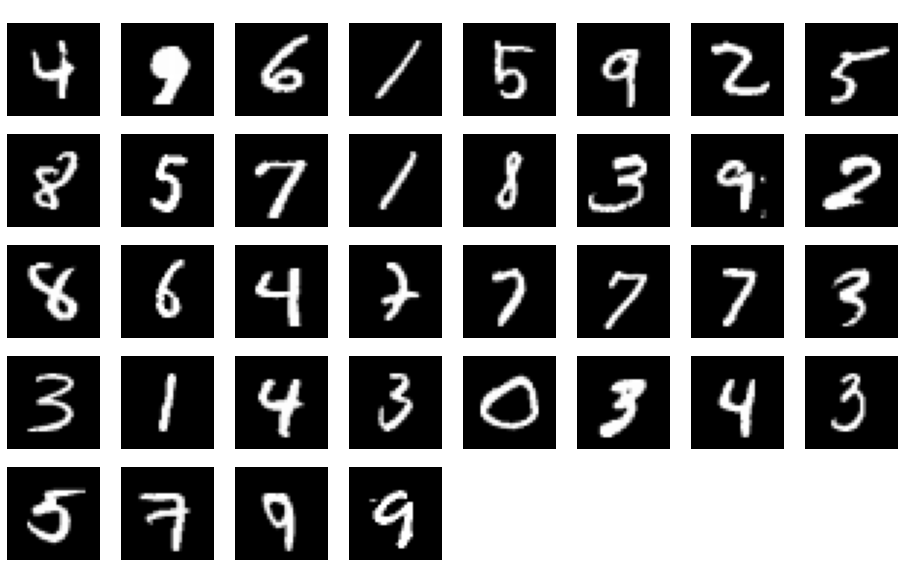

In [29]:
#visualization

images , labels= next(iter(train_loader))
plt.figure(figsize=(16,16))
plt.subplot(321)
for i in range(36):
    ax1 = plt.subplot(8,8,i+1)
    plt.imshow(images[i+1].reshape((32,32)).detach().numpy(), cmap='gray')
    plt.title(labels[i+1].item())
    plt.axis('off')
plt.show()

In [30]:
#model architecture

class LeNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=(0,0)) #padding of 2 as MNIST images are 28x28 so to make them 32x32 which is what was used in model
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1), padding=(0,0))
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x)) # num_ex x 120, 1, 1 --> num_ex x 120
        x = x.reshape((x.shape[0], -1))
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

model = LeNet().to(device)
summary(model, (1,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [31]:
def evaluation(dataloader, model):
    total, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            prob, num = torch.max(pred.data, dim = 1)
            total += labels.shape[0]
            correct += (num == labels).sum().item()

    model.train()
    return 100 * (correct/total)

        

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [38]:
def fit_model(model, train_loader, epochs):
    loss_arr = []
    loss_epoch_arr = []

    for epoch in range(epochs):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            loss_arr.append(loss.item())

        loss_epoch_arr.append(loss.item())
        print(f'epoch: {epoch+1} | Train set accuracy : {evaluation(train_loader, model)}')

    plt.title("Loss per Epoch")
    plt.plot(loss_epoch_arr)
    plt.show()
    print(f'Test set accuracy is {evaluation(test_loader, model)}%')


    
     



epoch: 1 | Train set accuracy : 99.91833333333334
epoch: 2 | Train set accuracy : 99.84666666666666
epoch: 3 | Train set accuracy : 99.36
epoch: 4 | Train set accuracy : 99.885
epoch: 5 | Train set accuracy : 99.81833333333333
epoch: 6 | Train set accuracy : 99.95833333333334
epoch: 7 | Train set accuracy : 99.59833333333333
epoch: 8 | Train set accuracy : 99.94
epoch: 9 | Train set accuracy : 99.91166666666666
epoch: 10 | Train set accuracy : 99.89166666666667
epoch: 11 | Train set accuracy : 99.79666666666667
epoch: 12 | Train set accuracy : 99.80333333333333
epoch: 13 | Train set accuracy : 99.91333333333333
epoch: 14 | Train set accuracy : 99.97
epoch: 15 | Train set accuracy : 99.905
epoch: 16 | Train set accuracy : 99.91833333333334
epoch: 17 | Train set accuracy : 99.85000000000001
epoch: 18 | Train set accuracy : 99.93166666666666
epoch: 19 | Train set accuracy : 99.86666666666667
epoch: 20 | Train set accuracy : 99.87333333333333
epoch: 21 | Train set accuracy : 99.92999999999

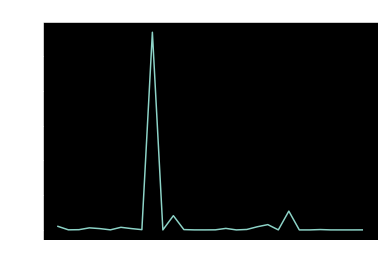

Test set accuracy is 98.95%


In [39]:
fit_model(model=model, train_loader=train_loader, epochs=epochs)

Image Shape:  torch.Size([64, 6, 28, 28])


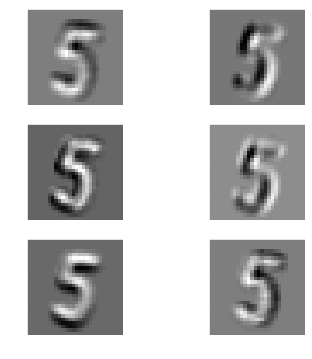

In [51]:
#Behaviour of Image in the first layer of the model

model = model.to('cpu')
layer_output = model.conv1(images)
print('Image Shape: ', layer_output.shape)

idx = 10

plt.figure(figsize = (6,6))
plt.subplot(321)

for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(layer_output[idx, i, :, :].detach().numpy(), cmap = 'gray')

plt.show()

Shape : torch.Size([1, 32, 32])
Label : 7
torch.Size([1, 1, 32, 32])


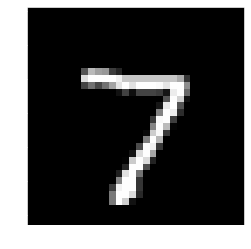

In [52]:
img , label = test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Shape :',img.shape)
print('Label :',label)
print(img.unsqueeze(0).shape)


In [56]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim = 1)
    return pred[0].item()

Label : 5 | Predicted: 5


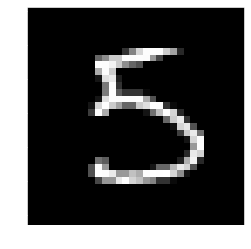

In [58]:
img, label = test_dataset[15]
plt.imshow(img[0], cmap='gray')
print(f'Label : {label} | Predicted: {predict_image(img, model)}')

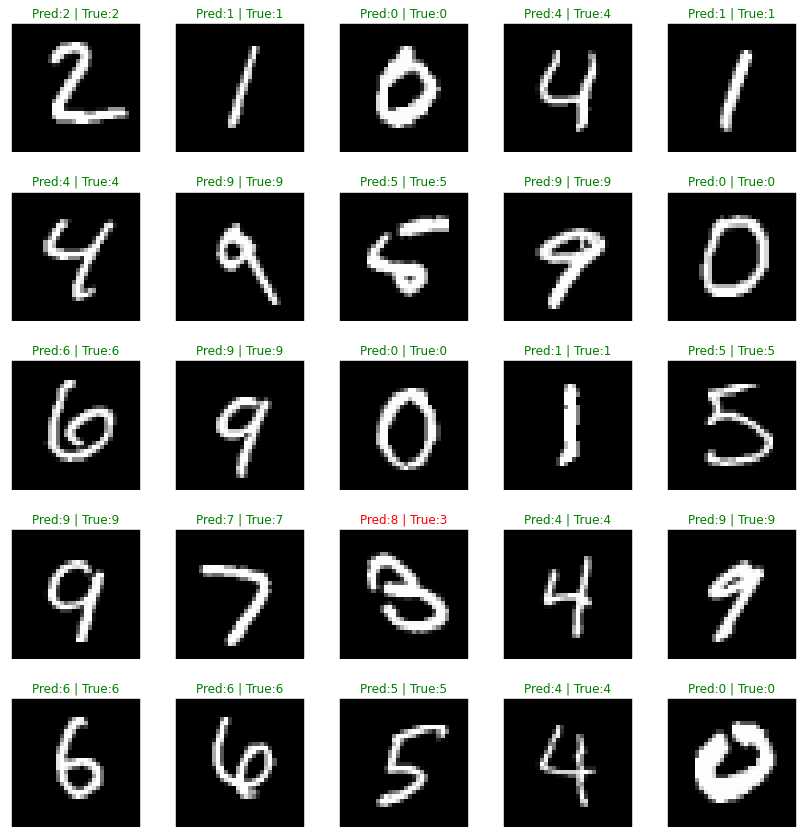

In [60]:
plt.figure(figsize=(12,12))
plt.subplot(321)
for i in range(25):
    ax1 = plt.subplot(5,5,i+1)
    img , label = test_dataset[i+1]
    plt.imshow(img[0],cmap='gray')
    if predict_image(img, model) == label:
        color = 'green'
    else:
        color = 'red'
    
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=2)
    plt.title('Pred:{} | True:{}'.format(predict_image(img,model),label),color=color)
plt.show()

In [61]:
torch.save(model.state_dict(), 'LeNet ~ MNIST.pth')